# Assignment-2: Manifold Learning

The objective of this assignment is to apply the concepts you have learned in class on Manifold Learning and Spectral Clustering. 

## Instructions
  - For each question you need to write the sub-problem formulation in markdown. 
  - Ensure that this notebook runs without errors when the cells are run in sequence.
  - Plagiarism will not be tolerated.
  - Use only `python3` to run your code.
  - If you are facing issues running the notebook on your local system. Use google collab to run the notebook online. To run the notebook online, go to [google collab](!https://colab.research.google.com/notebooks/intro.ipynb). Go to `File  -> Upload Notebook` and import the notebook file.

__NOTE__: If you use online platforms, you will have to upload `swissroll.dat` file separately and change the path in the code cell which loads the data.

## Submission  
- Rename the notebook to `<roll_number>.ipynb` and submit **ONLY** the notebook file on moodle.

## Problems 
 - Question 1: Spectral Clustering (10 marks)
 - Question 2: Manifold Visualization (10 marks)
 - Question 3: Clustering and Visualizing high-dimensional data (10 marks)
 - Question 4: Classification (10 marks)

## Deadline 
The deadline of this assignment is 27th April, 2020, 11:59 PM

In [1]:
import sys
# Install packages correctly
!{sys.executable} -m pip install numpy sklearn tensorflow keras
# Fix mpl version due to subtle API differences
!{sys.executable} -m pip install matplotlib==3.0.3

import numpy as np
import sklearn
import matplotlib.pyplot as plt

You are using pip version 18.0, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.0, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Question 1: Spectral Clustering

Implement spectral clustering and evaluate on the given concentric circles dataset for this question.

## Part 1: Implementation
Implement spectral clustering function from scratch (for two clusters), taking as input the dataset. It must return the predicted clustering. Assume that the graph constructed is a fully connected graph. Use the normalized graph laplacian for this case.



In [2]:
# Part 1: Spectral Clustering
from sklearn.metrics.pairwise import euclidean_distances

def spectral_clustering(X):
    # Your code here
    Adjacent = euclidean_distances(X)
    np.fill_diagonal(Adjacent,0)
    W = np.exp((Adjacent)*(-0.5/(0.1*0.1)))
    np.fill_diagonal(W, 0)
    Degree = np.diag(W.sum(axis=1))
    
    Laplacian = Degree-W
    Inv_Degree = np.linalg.pinv(np.sqrt(Degree))
    Normal_laplacian = np.dot(Inv_Degree, np.dot(Laplacian, Inv_Degree))
    eval, evec = np.linalg.eig(Normal_laplacian)

    evec = evec[:,np.argsort(eval)]
    eval = eval[np.argsort(eval)]

    Y_pred = evec[:,1] > 0
    return Y_pred

## Part 2: Clustering concentric circles
Perform spectral clustering on the concentric circles dataset. Visualize the result by plotting it on a 2-d graph. Use different colours for different clusters.

In [3]:
# DO NOT EDIT

from sklearn.datasets import make_circles 

CX, CY = make_circles(n_samples=200, shuffle=True,noise=0.05, random_state=1337, factor=0.5)

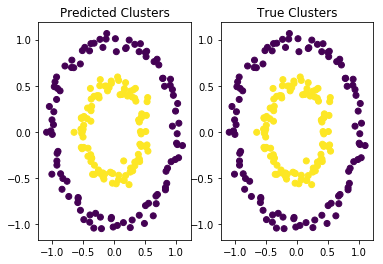

In [4]:
# Part 2: Perform Spectral Clustering on the concentric circles dataset
# Plot using colors from CY (true clusters) and CY_pred (predicted clusters)
# Code in this cell should plot 2 subplots (true labels and predicted labels)
SC_pred = spectral_clustering(CX)

fig = plt.figure()
ax = fig.add_subplot("121")
ax.set_title("Predicted Clusters")
ax.scatter(CX[:, 0], CX[:, 1], c = SC_pred)

ax1 = fig.add_subplot("122")
ax1.set_title("True Clusters")
ax1.scatter(CX[:, 0], CX[:, 1], c = CY)

plt.show()

## Part 3: Evaluate accuracy
Evaluate the accuracy of the clustering by comparing it with the true labels. Create two subplots (true vs predicted) with the color of each point showing the cluster label.

In [5]:
# Part 3: Report the accuracy of clustering
acc = 0
for i in range(CX.shape[0]):
    if CY[i] == SC_pred[i]: #opposite labels
        acc+=1
print("Accuracy is ",(acc/CX.shape[0])*100)

Accuracy is  100.0




---



# Question 2: Manifold Visualization
Implement the various manifold learning methods and visualize the given datasets.


## Part 1: MDS
Implement Multi-Dimensional Scaling

In [6]:
# Part 1: MDS
from sklearn.metrics.pairwise import euclidean_distances 
def MDS(X, k, output_dim=2):
    """Args:
    X: numpy.array [n_samples, input_dim]
    k: number of nearest neighbours to construct the knn graph
    output_dim: dimension of output data

    Returns:
    Y: numpy.array [n_samples, output_dim]
    """
    # Your code here

    N = X.shape[0]
    E = euclidean_distances(X)
    I = np.identity(N)
    e = np.ones(N)
    e = np.ones(N).reshape((N,1))
    e_t = np.ones(N).reshape((1,N))
    H = I-(1/N)*np.matmul(e,e_t)
    K = (-1/2)*np.matmul(H,np.matmul(E,H))
    eval, evec = np.linalg.eigh(K)
    idx = np.argsort(-(eval))
    vec = evec[:,idx[0:output_dim]]
    val = eval[idx[0:output_dim]]
    Y = np.sqrt(val)*vec
    return Y

## Part 2: LLE
Implement Locally Linear Embedding function

In [7]:
# Part 2: LLE
from sklearn.neighbors import NearestNeighbors as NN 
def LLE(X, k, output_dim=2):
    """Args:
    X: numpy.array [n_samples, input_dim]
    k: number of nearest neighbours to construct the knn graph
    output_dim: dimension of output data

    Returns:
    Y: numpy.array [n_samples, output_dim]
    """
    # Your code here
    
    N = X.shape[0]
    dim = X.shape[1]
    nbs = NN(n_neighbors=k+1).fit(X)
    dist, indices = nbs.kneighbors(X)
    idx = indices[:,1:]
    e = np.ones(k).reshape((k,1))
    e_t = np.ones(k).reshape((1,k))
    W = np.zeros((N,N))
    for i in range(N):
        X_t = X[i].reshape((dim,1))
        V = np.transpose(X[idx[i]])
        G1 = np.matmul(X_t,e_t)-V
        G = np.matmul(np.transpose(G1),G1)
        w = np.matmul(np.linalg.pinv(G),e)
        w = w/(np.sum(w))
        w = w.reshape(-1)
        W[idx[i],i] = w
    I = np.identity(N)
    M = np.matmul(I-W,np.transpose(I-W))
    eval, evec = np.linalg.eigh(M)
    idx = np.argsort(eval)
    evec = evec[:,idx]
    Y = evec[:,1:output_dim+1]
    return Y

## Part 3: ISOMAP
Implement Isomap Visualization  

In [8]:
# Part 3: Isomap
from sklearn.neighbors import kneighbors_graph
from sklearn.utils.graph_shortest_path import graph_shortest_path as short_path
def ISOMAP(X, k, output_dim=2):
    """Args:
    X: numpy.array [n_samples, input_dim]
    k: number of nearest neighbours to construct the knn graph
    output_dim: dimension of output data

    Returns:
    Y: numpy.array [n_samples, output_dim]
    """
    # Your code here
    N = X.shape[0]
    Adj = kneighbors_graph(X,n_neighbors=k,mode='distance').toarray()
    sp = short_path(Adj,directed=False)
    sp = sp*sp
    e = np.ones(N)
    I = np.identity(N)
    e = np.ones(N).reshape((N,1))
    e_t = np.ones(N).reshape((1,N))
    H = I-(1/N)*np.matmul(e,e_t)
    K = (-1/2)*np.matmul(H,np.matmul(sp,H))
    eval, evec = np.linalg.eigh(K)
    idx = np.argsort(-(eval))
    vec = evec[:,idx[0:output_dim]]
    val = eval[idx[0:output_dim]]
    Y = np.sqrt(val)*vec

    return Y

## Part 3: Manifold Visualization
Visualize the S-shaped 3-d dataset using the MDS, ISOMAP, LLE

In [9]:
# DO NOT EDIT

from sklearn import manifold, datasets

SX, St = datasets.make_s_curve(n_samples=1000, random_state=1337)
# SX: input data [n_samples, 3]
# St: univariate position along manifold [n_samples], use for coloring the plots

The code in the next cell should draw a single plot with the following subplots:
1. 3D S-shaped dataset
2. 2D Manifold learnt using MDS
3. 2D Manifold learnt using ISOMAP
4. 2D Manifold learnt using LLE

Use the `St` variable to color the points in your visualizations. Use a color spectrum, and the position along the manifold to assign the color.

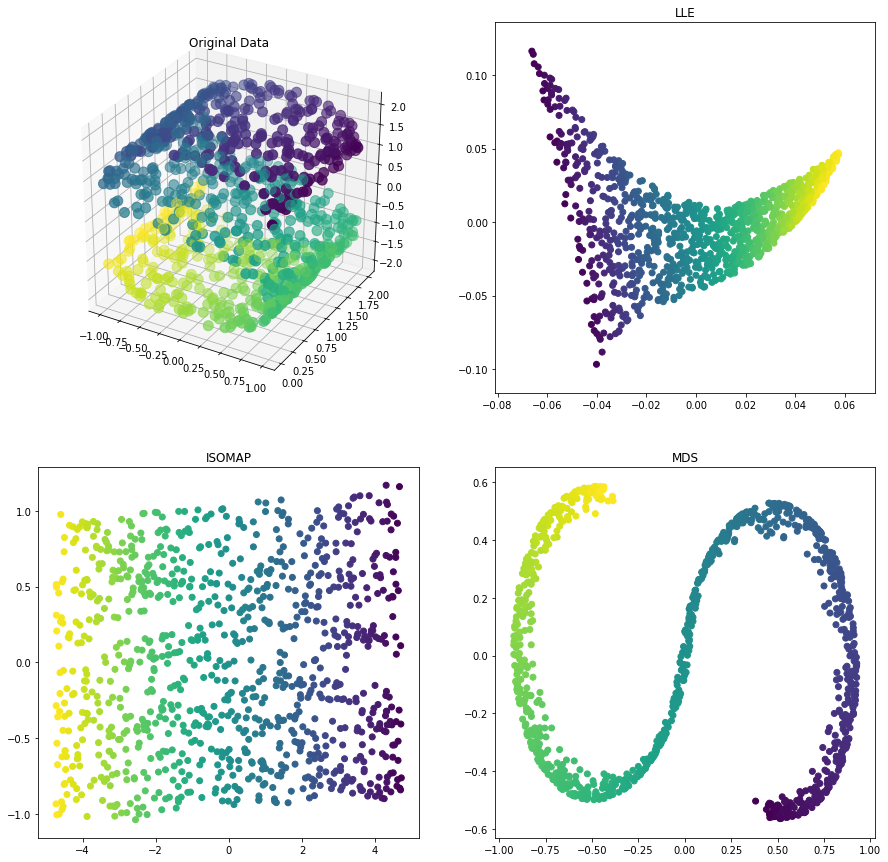

In [10]:
#  Visualization code here
fig = plt.figure(figsize=(15,15))
from mpl_toolkits.mplot3d import Axes3D

#Original Data
ax1 = fig.add_subplot("221",projection='3d')
ax1.set_title("Original Data")
ax1.scatter(SX[:,0],SX[:,1],SX[:,2],c=St,s=100)

#LLE
Y = LLE(SX,20)
ax2 = fig.add_subplot("222")
ax2.set_title("LLE")
ax2.scatter(Y[:, 0], Y[:, 1], c = St)

#ISOMAP
Y = ISOMAP(SX,20)
ax2 = fig.add_subplot("223")
ax2.set_title("ISOMAP")
ax2.scatter(Y[:, 0], Y[:, 1], c = St)

#MDS
Y = MDS(SX,2)
ax2 = fig.add_subplot("224")
ax2.set_title("MDS")
ax2.scatter(Y[:, 0], Y[:, 1], c = St)


plt.show()


# Question 3: Clustering and Visualizing high-dimensional data
Perform k-means and spectral clustering on the Swiss roll dataset and visualize using the above 3 methods. State your observations.

In [11]:
# Swiss roll dataset loading here
d = []
with open('./swissroll.dat', 'r') as dat_file:
    for line in dat_file:
        line = line.strip().split()
        line = [float(x.strip()) for x in line]
        d.append(line)
swissroll = np.array(d)
print (swissroll.shape)

(1600, 3)


Procedure for this question:
1. Perform spectral clustering (2 clusters) on the unchanged Swiss roll and visualize (binary colors)
2. Unwrap the manifold in 2D and visualize using
  - MDS
  - ISOMAP
  - LLE

Use the labels from the spectral clustering to color the unwrapped manifolds.

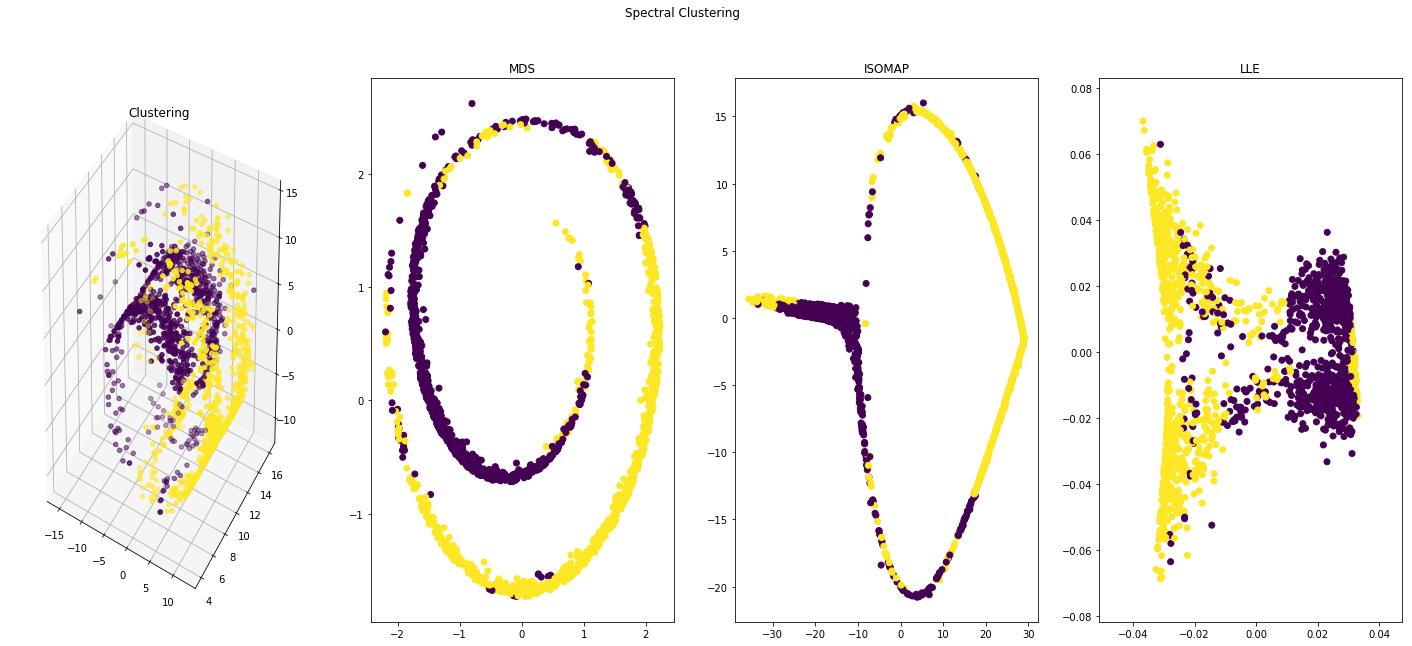

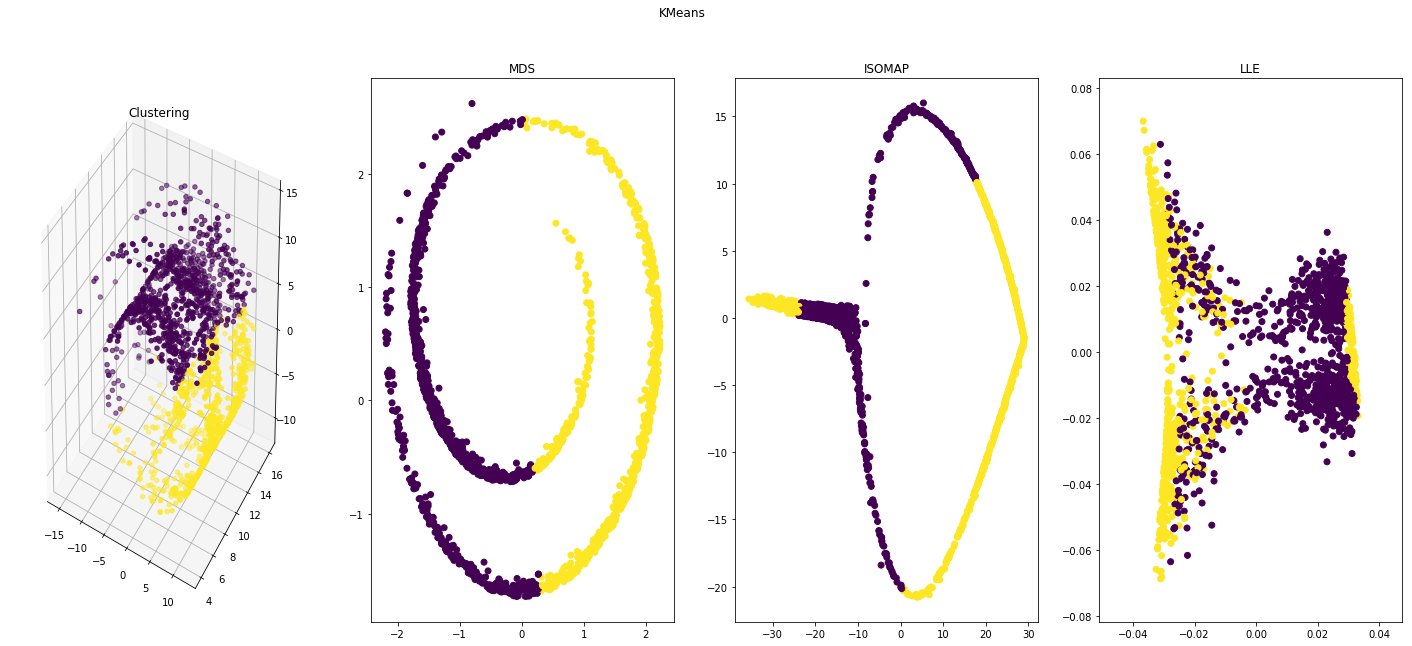

In [12]:
# CODE HERE
Y_pred = spectral_clustering(swissroll)

fig = plt.figure(figsize=(25,10))
from mpl_toolkits.mplot3d import Axes3D

#spectral Data
fig.suptitle("Spectral Clustering")
ax1 = fig.add_subplot("141",projection='3d')
ax1.set_title("Clustering")
ax1.scatter(swissroll[:,0],swissroll[:,1],swissroll[:,2],c=Y_pred)

#MDS
Y = MDS(swissroll,2)
ax2 = fig.add_subplot("142")
ax2.set_title("MDS")
ax2.scatter(Y[:, 0], Y[:, 1], c = Y_pred)

#ISOMAP
Y = ISOMAP(swissroll,20)
ax2 = fig.add_subplot("143")
ax2.set_title("ISOMAP")
ax2.scatter(Y[:, 0], Y[:, 1], c = Y_pred)

#LLE
Y = LLE(swissroll,20)
ax2 = fig.add_subplot("144")
ax2.set_title("LLE")
ax2.scatter(Y[:, 0], Y[:, 1], c = Y_pred)

#Kmeans
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2).fit(swissroll)
klabels = kmeans.labels_
fig = plt.figure(figsize=(25,10))
fig.suptitle("KMeans")
ax1 = fig.add_subplot("141",projection='3d')
ax1.set_title("Clustering")
ax1.scatter(swissroll[:,0],swissroll[:,1],swissroll[:,2],c=klabels)

#MDS
Y = MDS(swissroll,2)
ax2 = fig.add_subplot("142")
ax2.set_title("MDS")
ax2.scatter(Y[:, 0], Y[:, 1], c = klabels)

#ISOMAP
Y = ISOMAP(swissroll,20)
ax2 = fig.add_subplot("143")
ax2.set_title("ISOMAP")
ax2.scatter(Y[:, 0], Y[:, 1], c = klabels)

#LLE
Y = LLE(swissroll,20)
ax2 = fig.add_subplot("144")
ax2.set_title("LLE")
ax2.scatter(Y[:, 0], Y[:, 1], c = klabels)


plt.show()

## Observations

- Using Kmeans clustering, gives undesirable results as it does not classify the datapoints along the manifold.
- Using Spectral clustering, the datapoints are classified along the manifold, giving accurate classification.

- MDS cannot unroll the swissroll, as no information related to manifold is incorporated during dimensionality reduction
- ISOMAP and LLE finds the hole but this distorts the unfolding of the set
- Spectral Clustering on the 2D data separates the datapoints along the manifold accurately as compared to Kmeans clustering

#### Swissroll data has a hole in the center which induces non-convexity and makes it difficult for the manifold learning methods to unfold the data along the manifold.


# Question 4: Classification

Perform classification using a machine learning algorithm of your choice. Use 6k images from CIFAR-10 dataset.(5k images for training and 1k images for testing.)


*   Do dimensionality reduction on the dataset using PCA and ISOMAP.
*   Apply the classification algorithm.
*   Compare the results by changing the dimensionality of the data.
*   Use F1-score as metric.
*   Approach: Reduce the dimensionality into any two dimensions(of your choice) which are less than the initial dimensionality of the data using PCA and ISOMAP. Compare the performance metrics(F1-score) for the low dimensional data.



In [13]:
# Code for loading CIFAR-10 dataset.
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train[:5000].reshape([5000,32*32*3])
y_train = y_train[:5000].reshape(-1)
X_test = X_test[:1000].reshape([1000,32*32*3])
y_test = y_test[:1000].reshape(-1)
# Initial dimensionality/number of features (32*32*3) = 3072.

Using TensorFlow backend.
/home/ksvsc/.virtualenvs/test_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ksvsc/.virtualenvs/test_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ksvsc/.virtualenvs/test_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ksvsc/.virtualenv

In [14]:
from sklearn.decomposition import PCA

def reductionUsingPCA(X, k, output_dim):
    """Args:
    X: numpy.array [n_samples, input_dim]
    k: number of nearest neighbours to construct the knn graph
    output_dim: dimension of output data

    Returns:
    pca_X: numpy.array [n_samples, output_dim]
    """
    # Enter your code here
    pca = PCA(n_components = output_dim)
    pca.fit(X)
    return pca

In [15]:
from sklearn.manifold import Isomap

def reductionUsingISOMAP(X, k, output_dim):
    """Args:
    X: numpy.array [n_samples, input_dim]
    k: number of nearest neighbours to construct the knn graph
    output_dim: dimension of output data

    Returns:
    isomap_X: numpy.array [n_samples, output_dim]
    """
    # Enter your code here
    embedding = Isomap(n_neighbors=k,n_components=output_dim).fit(X)
    return embedding

In [16]:
# Classification Algorithm 
# Extra functions here
from sklearn.linear_model import LogisticRegression as LR

def classification(X, model1):
    """Args:
    X: numpy.array [n_samples, input_dim]
    n_classes: number of classes

    Returns:
    labels: numpy_array [n_samples]
    """
    # Your code here
    predictions = model1.predict(X)
    return predictions

In [17]:
from sklearn.metrics import f1_score

def F1_score(y_true, y_pred):
    """Args:
    y_true: numpy.array [n_samples] , ground truth value
    y_pred: numpy.array [n_samples] , predicted value by classifier

    Returns:
    score: float, f1-score
    """
    # Enter your code here
    score = f1_score(y_true, y_pred, average='micro') 
    return score

In [ ]:
def calculate_score_PCA(X_train,y_train,X_test,y_test,dim):
  pca = reductionUsingPCA(X_train,dim,dim)
  X_train_pca = pca.transform(X_train)
  X_test_pca = pca.transform(X_test)
  model_1 = LR(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train_pca,y_train)
  y_pred_pca = classification(X_test_pca, model_1)
  print(F1_score(y_test,y_pred_pca))

def calculate_score_Isomap(X_train,y_train,X_test,y_test,dim):
  iso = reductionUsingISOMAP(X_train,dim,dim)
  X_train_iso = iso.transform(X_train)
  X_test_iso = iso.transform(X_test)
  model_1 = LR(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train_iso,y_train)
  y_pred_iso = classification(X_test_iso, model_1)
  print(F1_score(y_test,y_pred_iso))

print("F1 score for PCA with dim ",100)
calculate_score_PCA(X_train,y_train,X_test,y_test,100)
print("F1 score for PCA with dim ",500)
calculate_score_PCA(X_train,y_train,X_test,y_test,500)
print("F1 score for Isomap with dim ",100)
calculate_score_Isomap(X_train,y_train,X_test,y_test,100)
print("F1 score for Isomap with dim ",500)
calculate_score_Isomap(X_train,y_train,X_test,y_test,500)

F1 score for PCA with dim  100


/home/ksvsc/.virtualenvs/test_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.36499999999999994
F1 score for PCA with dim  500


/home/ksvsc/.virtualenvs/test_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.288
F1 score for Isomap with dim  100


### we have done dimensionality reduction on cifar data using PCA and Isomaps 

F1 scores for PCA are better than Isomaps. because Pca preserves the inter class varaince. therefore, Pca out performs Isomaps for both the cases in classification of data.